In [1]:
import torchvision.transforms.v2 as v2
from torchvision.models.segmentation import fcn_resnet50
from torch import optim
import torch

from pathlib import Path
from dlvc.dataset.oxfordpets import OxfordPetsCustom
from dlvc.utils import display_images_and_masks
from dlvc.trainer import ImgSemSegTrainer
from dlvc.metrics import SegMetrics
from dlvc.utils import AddTransform
from dlvc.utils import Resnet50Wrapper


In [2]:
oxford_pets_path = "data/"
train_transform = v2.Compose([v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Resize(size=(64,64), interpolation=v2.InterpolationMode.NEAREST),
                        v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])])
train_transform2 = v2.Compose([v2.ToImage(), 
                        v2.ToDtype(torch.long, scale=False),
                        v2.Resize(size=(64,64), interpolation=v2.InterpolationMode.NEAREST),
                        AddTransform()])#,

val_transform = v2.Compose([v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Resize(size=(64,64), interpolation=v2.InterpolationMode.NEAREST),
                        v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])])
val_transform2 = v2.Compose([v2.ToImage(), 
                        v2.ToDtype(torch.long, scale=False),
                        v2.Resize(size=(64,64), interpolation=v2.InterpolationMode.NEAREST),
                        AddTransform()])

train_data = OxfordPetsCustom(root=oxford_pets_path, 
                        split="trainval",
                        target_types='segmentation', 
                        transform=train_transform,
                        target_transform=train_transform2,
                        download=True)

val_data = OxfordPetsCustom(root=oxford_pets_path, 
                        split="test",
                        target_types='segmentation', 
                        transform=val_transform,
                        target_transform=val_transform2,
                        download=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


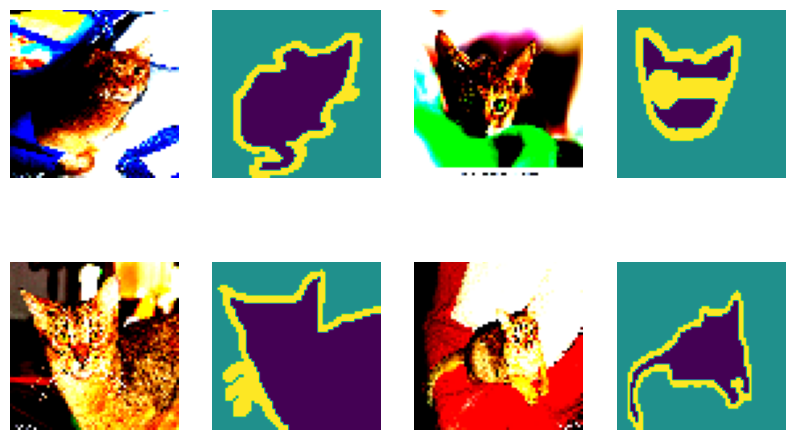

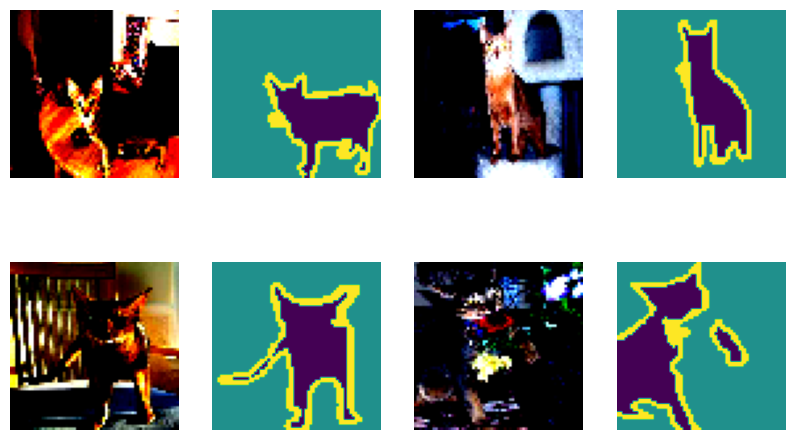

In [3]:
# Display 4 training and test images.
display_images_and_masks(train_data, indexes=(0, 1, 2, 3))
display_images_and_masks(val_data, indexes=(0, 1, 2, 3))

In [4]:
model = fcn_resnet50()
model = Resnet50Wrapper(model)



optimizer = optim.Adam(model.parameters())
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.09)
loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cpu")

segMetricsTrain = SegMetrics(train_data.classes_seg)
segMetricsVal = SegMetrics(val_data.classes_seg)


trainer = ImgSemSegTrainer(
    model,
    optimizer,
    loss_fn,
    lr_scheduler,
    segMetricsTrain,
    segMetricsVal,
    train_data,
    val_data,
    device,
    1,
    "assignment_2/weights/test_model.pt",
    batch_size=64,
    val_frequency=2
)

In [6]:
model

Resnet50Wrapper(
  (model): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

In [7]:
trainer.train()

train epoch: 100%|██████████| 58/58.0 [03:18<00:00,  3.41s/it]



TRAIN, EPOCH: 0 
Loss: 0.4493761956691742\mIoU: 0.47


val epoch: 100%|██████████| 58/58.0 [01:13<00:00,  1.26s/it]


VALIDATION, EPOCH: 0 
Loss: 0.43860822916030884\mIoU: 0.5
New metric is higher. Saving new best model


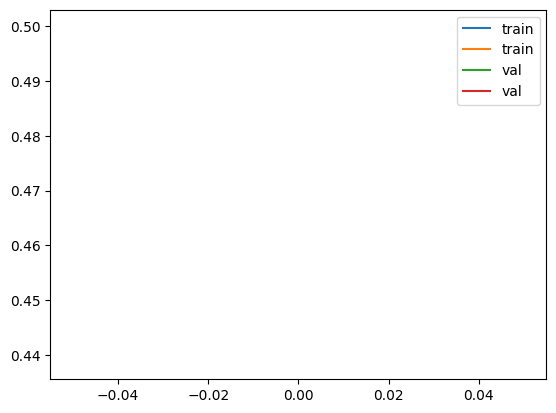

In [9]:
import matplotlib.pyplot as plt
train_metrics = trainer.metrics_train
val_metrics = trainer.metrics_val

plt.plot(train_metrics, label="train")
plt.plot(val_metrics, label="val")
plt.legend()

In [11]:
from torch.utils.data import DataLoader
loader = iter(DataLoader(train_data, 1))
img, label = next(loader)

In [12]:
prediction = model(img)
prediction

tensor([[[[-2.9091, -2.9091, -2.9091,  ..., -2.5251, -2.5251, -2.5251],
          [-2.9091, -2.9091, -2.9091,  ..., -2.5251, -2.5251, -2.5251],
          [-2.9091, -2.9091, -2.9091,  ..., -2.5251, -2.5251, -2.5251],
          ...,
          [-2.3835, -2.3835, -2.3835,  ..., -2.0955, -2.0955, -2.0955],
          [-2.3835, -2.3835, -2.3835,  ..., -2.0955, -2.0955, -2.0955],
          [-2.3835, -2.3835, -2.3835,  ..., -2.0955, -2.0955, -2.0955]],

         [[ 3.7196,  3.7196,  3.7196,  ...,  3.2479,  3.2479,  3.2479],
          [ 3.7196,  3.7196,  3.7196,  ...,  3.2479,  3.2479,  3.2479],
          [ 3.7196,  3.7196,  3.7196,  ...,  3.2479,  3.2479,  3.2479],
          ...,
          [ 3.3006,  3.3006,  3.3006,  ...,  2.8139,  2.8139,  2.8139],
          [ 3.3006,  3.3006,  3.3006,  ...,  2.8139,  2.8139,  2.8139],
          [ 3.3006,  3.3006,  3.3006,  ...,  2.8139,  2.8139,  2.8139]],

         [[-0.6875, -0.6875, -0.6875,  ..., -0.6359, -0.6359, -0.6359],
          [-0.6875, -0.6875, -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


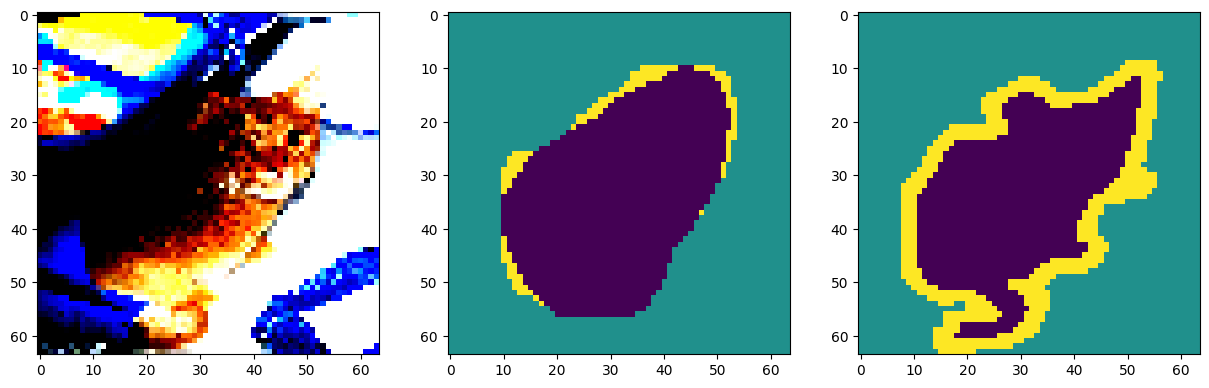

In [31]:
res = prediction.argmax(dim=1)
fig, ax = plt.subplots(1,3,figsize=(15,6))
ax[0].imshow(img.view([3,64,64]).permute(1,2,0))
ax[1].imshow(res.view(64,64))
ax[2].imshow(label.view(64,64))

torch.Size([64, 64, 3])